In [1]:
# Standard library imports
from datetime import datetime, timedelta

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
start_date = '2023-01-01'
end_date = '2024-08-01'
stocks = ['SMCI', 'NVDA', 'RR.L', 'META', 'CRWD', 'MDB', 'TSLA', 'AMD', 'ZS', 'PANW']
data = yf.download(stocks[0],start_date,end_date, interval='1h')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-01-03 09:30:00-05:00,83.080002,85.250000,83.000000,83.754997,83.754997,221397
2023-01-03 10:30:00-05:00,83.790001,83.949997,82.209999,82.250000,82.250000,114501
2023-01-03 11:30:00-05:00,82.300003,83.440002,81.940002,83.396500,83.396500,95571
2023-01-03 12:30:00-05:00,83.440002,84.379997,83.339996,84.349998,84.349998,74348
2023-01-03 13:30:00-05:00,84.209999,84.209999,83.013702,83.029999,83.029999,60236


In [6]:
def insert_ema_column(df, hours, column_to_ema, ema_column_name):
    side_df = df.copy()
    multiplier = 2 / (1 + hours)
    side_df.loc[hours, ema_column_name] = side_df.iloc[:hours][column_to_ema].mean()
    for day in range(hours + 1, len(side_df)):
        side_df.loc[day, ema_column_name] = side_df.loc[day - 1, ema_column_name] * (1 - multiplier) + side_df.loc[day, column_to_ema] * multiplier

    side_df[ema_column_name] = (side_df[column_to_ema] / side_df[ema_column_name] - 1)
    return side_df

def insert_sma_column(df, hours, column_to_sma, sma_column_name):
    side_df = df.copy()
    side_df[sma_column_name] = side_df[column_to_sma].rolling(hours).mean()

    side_df[sma_column_name] = (side_df[column_to_sma] / side_df[sma_column_name] - 1)
    
    return side_df

def insert_vwap_column(df, hours, vwap_column_name):
    side_df = df.copy()
    side_df[vwap_column_name] = side_df['Close'] * side_df['Volume']
    side_df[vwap_column_name] = side_df[vwap_column_name].rolling(hours).sum() / side_df['Volume'].rolling(hours).sum()

    side_df[vwap_column_name] = (side_df['Close'] / side_df[vwap_column_name] - 1)
    
    return side_df

def insert_stddev_column(df, hours, stddev_column_name):
    side_df = df.copy()
    side_df[stddev_column_name] = side_df['Close'].rolling(hours).std()
    
    return side_df

def insert_fama_french_column(df):

    ff_factors = pd.read_csv('Data/famafrench_daily_factor.csv')
    ff_factors.drop(['Date_str'], axis=1, inplace=True)
    ff_factors = ff_factors.set_index('Date')
    ff_factors.index = pd.to_datetime(ff_factors.index)
    
    fdf = ff_factors.reset_index()
    fdf = fdf[['Date', 'Mkt-RF']].rename(columns={'Mkt-RF': 'FamaFrenchMktReturns'})
    fdf = fdf[
        fdf['Date'] >= '2023-01-01'
    ]
    fdf['Date'] = pd.to_datetime(fdf['Date'])
    
    side_df = df.copy()
    side_df = side_df.reset_index(drop=True)
    side_df['Date'] = pd.to_datetime(side_df['Datetime'].dt.date)
    side_df = side_df.merge(fdf, how='left', on='Date')
    side_df = side_df.drop(['Date'], axis=1)
    side_df['FamaFrenchMktReturns'] = side_df['FamaFrenchMktReturns'].ffill()
    return side_df

In [7]:
df = data.copy()
df = df.reset_index()

trading_days_per_year = 252
hours_per_day = 6.5

# log return for each period (hourly)
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

hours_gridsearch = [2 ** i for i in range(1, 9)]

for index, hour in enumerate(hours_gridsearch):
    ema_column_name = f"EMAVolumeDiff{hour}"
    df = insert_ema_column(df, hour, 'Volume', ema_column_name)

    sma_column_name = f"SMAVolumeDiff{hour}"
    df = insert_sma_column(df, hour, 'Volume', sma_column_name)

    ema_column_name = f"EMACloseDiff{hour}"
    df = insert_ema_column(df, hour, 'Close', ema_column_name)
    
    sma_column_name = f"SMACloseDiff{hour}"
    df = insert_sma_column(df, hour, 'Close', sma_column_name)

    vwap_column_name = f"VWAP{hour}"
    df = insert_vwap_column(df, hour, vwap_column_name)

    stddev_column_name = f"VolatilityStdDev{hour}"
    df = insert_stddev_column(df, hour, stddev_column_name)
    
    # annualized volatility using a 5-day rolling window
    df[f'Volatility{hour}'] = df['Log_Return'].rolling(window=hour).std() * np.sqrt(hours_per_day * trading_days_per_year)
    
    # momentum from t-x hour
    df[f'Momentum{hour}'] = (df['Close'] / df['Close'].shift(hour))
    # df[f'Momentum{hour}'] = (df['Close'] / df['Close'].shift(hour)).clip(-1, 1)

df['PriceVolatilityHourly'] = ((df['High'] - df['Low']) - 1)
# df['PriceVolatilityHourly'] = ((df['High'] - df['Low']) - 1).clip(-1, 1)

### brb fixing normalization
for index, hour in enumerate(hours_gridsearch):
    if index <= 1:
        continue

    longer = f'EMACloseDiff{hour}'
    shorter = f'EMACloseDiff{hours_gridsearch[index - 1]}'
    signal = f'EMACloseDiff{hours_gridsearch[index - 2]}'
    df[f'MACD{hour}'] = (df[longer] - df[shorter]) / df[signal]

df = insert_fama_french_column(df)
df = df.dropna().reset_index(drop=True)
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Log_Return,EMAVolumeDiff2,SMAVolumeDiff2,...,Volatility256,Momentum256,PriceVolatilityHourly,MACD8,MACD16,MACD32,MACD64,MACD128,MACD256,FamaFrenchMktReturns
0,2023-02-24 13:30:00-05:00,97.259903,97.969902,96.809998,97.889999,97.889999,162598,0.007074,-0.011522,0.169707,...,0.728899,1.168766,0.159904,4.138951,2.046955,0.649950,0.389898,0.559972,0.942536,-1.09
1,2023-02-24 14:30:00-05:00,97.891098,98.360001,97.000000,97.339996,97.339996,299026,-0.005634,0.176426,0.295539,...,0.727519,1.183465,0.360001,-14.967468,7.645914,1.188432,0.541187,0.671433,1.054185,-1.09
2,2023-02-24 15:30:00-05:00,97.305000,98.190002,97.129997,98.169998,98.169998,262724,0.008491,0.010957,-0.064623,...,0.727021,1.177148,0.060005,4.233344,2.981742,1.037436,0.525654,0.625907,0.973667,-1.09
3,2023-02-27 09:30:00-05:00,98.860001,103.980003,98.699997,102.959999,102.959999,684667,0.047640,0.260734,0.445374,...,0.736192,1.220628,4.280006,1.130377,0.774288,0.448448,0.303530,0.379541,0.628150,0.31
4,2023-02-27 10:30:00-05:00,102.919998,103.839996,101.889999,102.802803,102.802803,384289,-0.001528,-0.121055,-0.281001,...,0.735016,1.238140,0.949997,4.010681,1.483437,0.677087,0.389404,0.427139,0.663667,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,2024-07-26 14:30:00-04:00,716.057495,718.500000,710.869995,714.880005,714.880005,392833,-0.001370,-0.031046,0.006790,...,0.664162,0.949073,6.630005,-2.074541,25.716635,-18.314887,7.459750,1.167287,0.293502,0.68
2482,2024-07-26 15:30:00-04:00,714.715027,714.826904,708.539978,712.200012,712.200012,326064,-0.003756,-0.075037,-0.092877,...,0.663666,0.935653,5.286926,-0.416749,2.717558,14.436167,5.085196,1.130195,0.296469,0.68
2483,2024-07-29 09:30:00-04:00,720.890015,730.000000,703.906006,711.039978,711.039978,1202835,-0.001630,0.308289,0.573466,...,0.662861,0.922362,25.093994,0.209332,2.533485,9.332173,4.801449,1.164175,0.307555,0.68
2484,2024-07-29 10:30:00-04:00,711.229980,711.950012,692.309998,699.469971,699.469971,710323,-0.016406,-0.089346,-0.257434,...,0.663936,0.913146,18.640015,0.593524,0.649130,1.652448,1.899275,0.844905,0.268207,0.68


In [8]:
df["Log_Return_shift"] = df["Log_Return"].shift(-1)
df=df.dropna()

In [9]:
target = "Log_Return_shift"
features = df.columns[8:-1]

In [10]:
features_numpy = df[features].to_numpy()
target_numpy = df[target].to_numpy()

pca = PCA(n_components=2)  # we shall just plot the top 2 components
features_pca = pca.fit_transform(features_numpy)
features_pca.shape

(2485, 2)

In [11]:
pca.explained_variance_ratio_,sum(pca.explained_variance_ratio_)

(array([0.39787524, 0.2955953 ]), 0.6934705359868358)

In [12]:
def split_and_scale_data(features_pca,target_numpy):

    # data
    X,y = features_pca,target_numpy

    # train test split
    # Split data into training and testing sets
    train_size,val_size,test_size = 0.7,0.2,0.1
    train_size,val_size,test_size = int(len(X)*train_size),int(len(X)*val_size),int(len(X)*test_size)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    print(X_test.shape, y_test.shape)
    
    # scale the data using StandardScaler - scale according to train data, then scale test data using train data statistics

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform the training data
    X_train = scaler.fit_transform(X_train)

    # Transform the test data
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train,y_train,X_val,y_val,X_test,y_test

X_train,y_train,X_val,y_val,X_test,y_test = split_and_scale_data(features_pca,target_numpy)

(1739, 2) (1739,)
(497, 2) (497,)
(249, 2) (249,)


In [42]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
# from tqdm import tqdm
from alive_progress import alive_it

def train():
    # initialise training params
    best_score = float('inf')
    best_params = None
    best_model = None
    

    # Define the parameter grid
    # param_grid={"learning_rate": (0.05, 0.10, 0.15),
    #             "max_depth": [ 3, 4, 6, 8],
    #             "min_samples_leaf": [0.001, 0.05, 0.1],
    #             "n_estimators": [100, 200, 500]
    #             },
    param_grid={"learning_rate": (0.05, 0.10, 0.15),
            "max_depth": [ 3, 4, 6, 8],
            "min_samples_leaf": [0.2],
            "n_estimators": [1000]
            },

    for params in alive_it(ParameterGrid(param_grid)):
        model = GradientBoostingRegressor(**params) # initialise new model before each run
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = mean_squared_error(y_val, y_pred)
        
        if score < best_score:
            best_score = score
            best_params = params
            best_model = model
            print(f"score: {round(best_score,7)}")
            # print(f"score: {round(best_score,7)}, params: {best_params}")

    print(f"Best parameters found: {best_params}")
    print(f"Best validation score: {round(best_score,5)}")

    return best_model, best_params, best_score, X_test, y_test

def predict(best_model,X_test, y_test):
    y_pred = best_model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    print(f"Test set mean squared error: {round(score,5)}")
    
    return y_pred

def train_predict():
    best_model, best_params, best_score, X_test, y_test = train()
    y_pred = predict(best_model,X_test, y_test)
    
    plt.plot(y_test,label='test groundtruth')
    plt.plot(y_pred,label='test predictions')
    plt.title(target)
    plt.legend()
    plt.show()
    
    return best_model, best_params, best_score, y_pred

on 0: score: 0.0005344
|████████████████████████████████████████| 12/12 [100%] in 17.8s (0.67/s) 
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 0.2, 'n_estimators': 1000}
Best validation score: 0.00053
Test set mean squared error: 0.00028


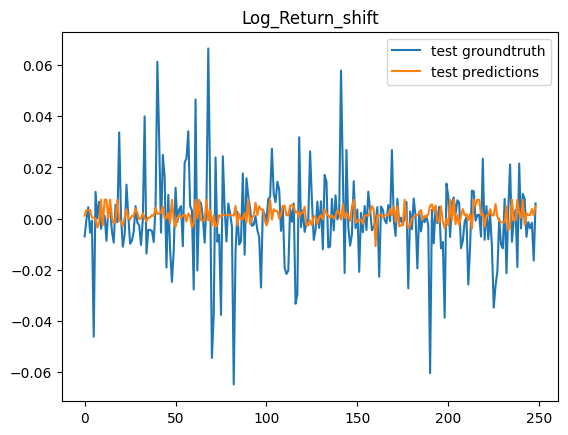

In [43]:
best_model, best_params, best_score, y_pred = train_predict()

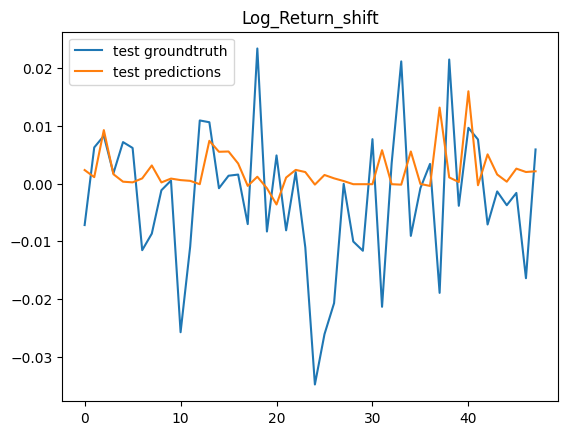

In [35]:
plt.plot(y_test[-48:] ,label='test groundtruth')
plt.plot(y_pred[-48:] ,label='test predictions')
plt.title(target)
plt.legend()
plt.show()